In [74]:
import os
import numpy as np
from datetime import datetime

def parse_timestamp(ts_str):
    return datetime.fromtimestamp(int(ts_str) / 1000.0)

def parse_measurements(exp_hash, run_number, log_dir='.'):
    path = os.path.join(log_dir, f"{exp_hash}_measurements_{run_number}.log")
    parsed = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 17:
                continue
            ts = parse_timestamp(parts[0])
            matrix = np.array(list(map(float, parts[1:])), dtype=np.float32).reshape(4, 4)
            parsed.append({'timestamp': ts, 'data': matrix})
    return parsed

def parse_robotstate(exp_hash, run_number, log_dir='.'):
    path = os.path.join(log_dir, f"{exp_hash}_robotstate_{run_number}.log")
    parsed = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 25:
                continue
            ts = parse_timestamp(parts[0])
            pose_matrix = np.array(list(map(float, parts[1:17]))).reshape(4, 4)
            joint_config = list(map(float, parts[17:24]))
            state = float(parts[24])
            parsed.append({
                'timestamp': ts,
                'data': pose_matrix,
                'joints': joint_config,
                'state': state
            })
    return parsed

def parse_kalmanfilter(exp_hash, run_number, log_dir='.'):
    path = os.path.join(log_dir, f"{exp_hash}_kalmanfilter_{run_number}.log")
    parsed = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 7:
                continue
            ts = parse_timestamp(parts[0])
            position = list(map(float, parts[1:4]))
            velocity = list(map(float, parts[4:7]))
            parsed.append({'timestamp': ts, 'position': position, 'velocity': velocity})
    return parsed

def parse_controller_input(exp_hash, run_number, log_dir='.'):
    path = os.path.join(log_dir, f"{exp_hash}_controllerinput_{run_number}.log")
    parsed = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 17:
                continue
            ts = parse_timestamp(parts[0])
            matrix = np.array(list(map(float, parts[1:])), dtype=np.float32).reshape(4, 4)
            parsed.append({'timestamp': ts, 'data': matrix})
    return parsed

def parse_filtered_position(exp_hash, run_number, log_dir='.'):
    path = os.path.join(log_dir, f"{exp_hash}_filteredposition_{run_number}.log")
    parsed = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 4:
                continue
            ts = parse_timestamp(parts[0])
            position = list(map(float, parts[1:4]))
            parsed.append({'timestamp': ts, 'position': position})
    return parsed


In [75]:

exp_hash = '#1'
run_number = 1
log_dir = '/dev/shm/experiment'


In [85]:
import matplotlib.pyplot as plt

SHADE_COLORS = [
    "#f0e442", "#56b4e9", "#e69f00", "#009e73",
    "#d55e00", "#cc79a7", "#0072b2", "#999999",
    "#bcbcbc", "#e0bbff", "#ffd999", "#a1d99b"
]

PLOT_COLORS = {
    'robotstate': '#1f77b4',    # blue
    'measurements': '#ff7f0e',  # orange
    'kalman': '#2ca02c',        # green
    'controller': '#d62728',    # red
}

def plot_position_comparison(
    axis,
    exp_hash, 
    run_number,
    log_dir,
    visibility=[1, 1, 1, 1],
    visible_states=[2],
    shade_states=False
):
    
    measurements = parse_measurements(exp_hash, run_number, log_dir)
    robotstate = parse_robotstate(exp_hash, run_number, log_dir)
    kalman = parse_kalmanfilter(exp_hash, run_number, log_dir)
    controller_input = parse_controller_input(exp_hash, run_number, log_dir)
    filtered = parse_filtered_position(exp_hash, run_number, log_dir)
    
    axis_map = {'x': 0, 'y': 1, 'z': 2}
    if axis not in axis_map:
        raise ValueError("axis must be one of 'x', 'y', 'z'")
    idx = axis_map[axis]

    # === 1. Determine start/end time from robotstate for selected states
    state_set = set(visible_states)
    timestamps = [entry['timestamp'] for entry in robotstate if int(entry['state']) in state_set]
    if not timestamps:
        raise ValueError(f"No robotstate entries found for states {visible_states}")
    start_time = min(timestamps)
    end_time = max(timestamps)

    # === 2. Convert entries to (relative_time_in_seconds, value) pairs
    def process(data, get_value_fn):
        return [
            ((entry['timestamp'] - start_time).total_seconds(), get_value_fn(entry))
            for entry in data
            if start_time <= entry['timestamp'] <= end_time
        ]

    rs_data = process(robotstate, lambda e: e['data'][:3, 3][idx]) if visibility[0] else []
    meas_data = process(measurements, lambda e: e['data'][:3, 3][idx]) if visibility[1] else []
    kf_data = process(kalman, lambda e: e['position'][idx]) if visibility[2] else []
    ctrl_data = process(controller_input, lambda e: e['data'][:3, 3][idx]) if visibility[3] else []

    # === 3. Begin plotting
    plt.figure(figsize=(10, 6))
    ax = plt.gca()

    if rs_data:
        times, values = zip(*rs_data)
        ax.scatter(times, values, label='Robot State', s=1, color=PLOT_COLORS['robotstate'])

    if meas_data:
        times, values = zip(*meas_data)
        ax.scatter(times, values, label='Measurements', s=1, color=PLOT_COLORS['measurements'])

    if kf_data:
        times, values = zip(*kf_data)
        ax.scatter(times, values, label='Kalman Filter', s=1, color=PLOT_COLORS['kalman'])

    if ctrl_data:
        times, values = zip(*ctrl_data)
        ax.scatter(times, values, label='Controller Input', s=1, color=PLOT_COLORS['controller'])

    # === 4. Optional shaded regions (no text)
    if shade_states:
        segments = []
        current_state = None
        current_start = None

        for entry in robotstate:
            t = entry['timestamp']
            s = int(entry['state'])

            if t < start_time:
                continue
            if t > end_time:
                break

            if s != current_state:
                if current_state is not None:
                    segments.append((current_start, t))
                current_state = s
                current_start = t

        if current_state is not None:
            segments.append((current_start, end_time))

        for i, (seg_start, seg_end) in enumerate(segments):
            rel_start = (seg_start - start_time).total_seconds()
            rel_end = (seg_end - start_time).total_seconds()
            color = SHADE_COLORS[i % len(SHADE_COLORS)]
            ax.axvspan(rel_start, rel_end, facecolor=color, alpha=0.1)

    # === 5. Final formatting
    state_range_str = f"{visible_states[0]}–{visible_states[-1]}" if len(visible_states) > 1 else str(visible_states[0])
    plt.title(f"{axis.upper()} Position (States: {state_range_str})")
    plt.xlabel("Time (s)")
    plt.ylabel(f"{axis.upper()} Position (m)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [86]:
"""
MoveToStartingPoint 0
RestartServer 1
Idle 2
Registration 3
ComputingApproachPoint 4 
Approaching 5
VisualServoing 6 
Lifting 7
"""

"""
robotstate
measurements
kalman
controller_input
"""

'\nrobotstate\nmeasurements\nkalman\ncontroller_input\n'

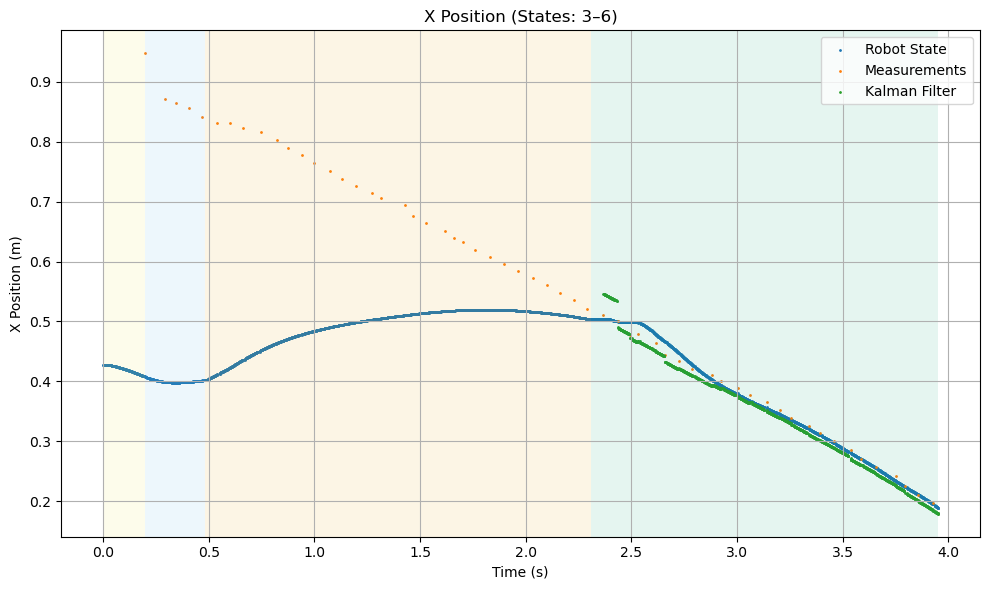

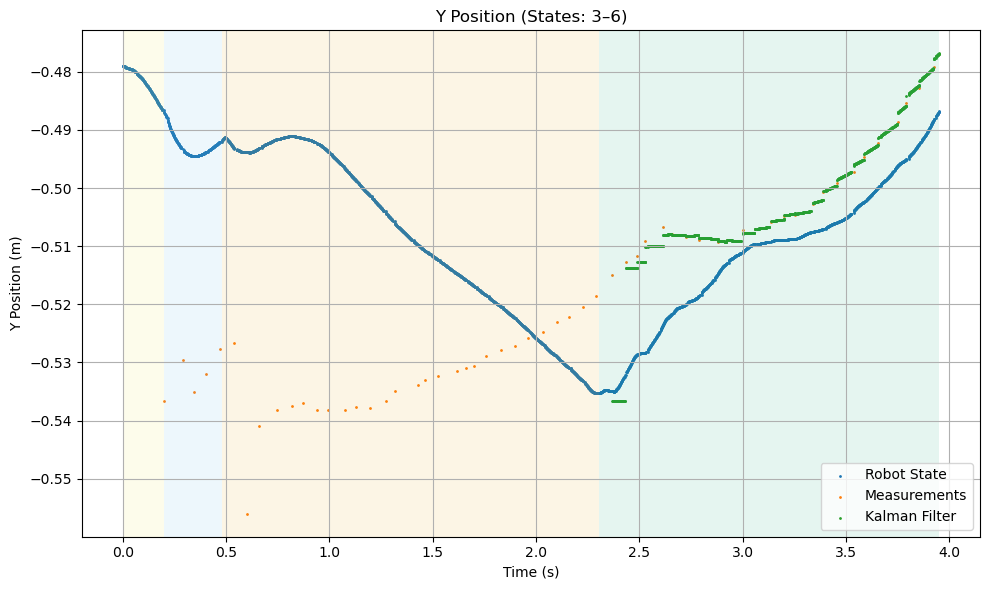

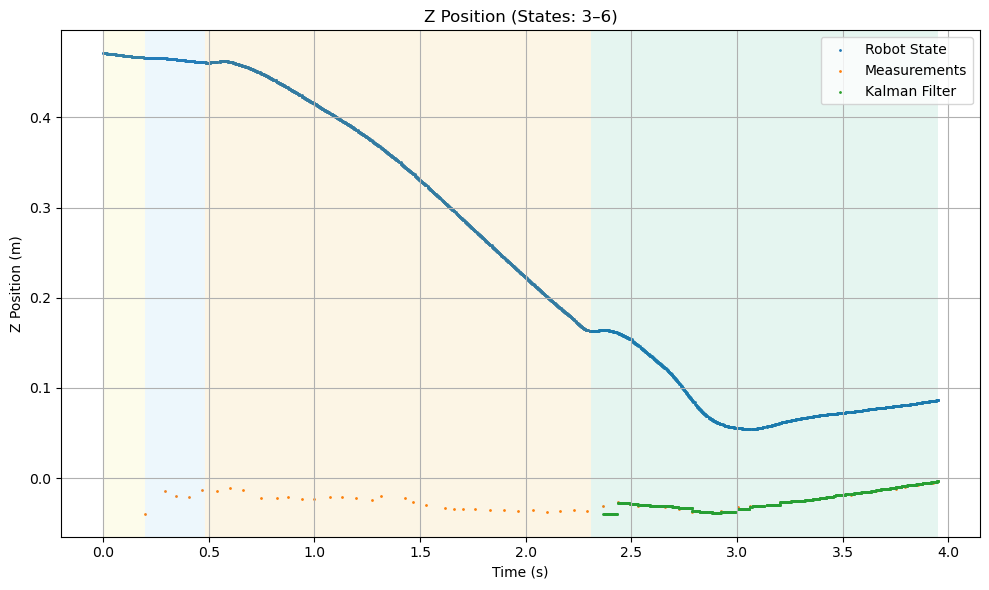

In [92]:
for dim in ['x', 'y', 'z']:
    plot_position_comparison(
        dim,
        '#1',
        2,
        '/dev/shm/experiment',
        visibility=[1, 1, 1, 0],
        visible_states=[3, 4, 5, 6],
        shade_states=True
    )

In [70]:
def plot_multi_run_position_comparison(
    axis,
    exp_hashes,
    run_numbers,
    log_dir='.',
    visibility=[1, 1, 1, 1],
    visible_states=[2],
    shade_states=False
):
    axis_map = {'x': 0, 'y': 1, 'z': 2}
    if axis not in axis_map:
        raise ValueError("axis must be one of 'x', 'y', 'z'")
    idx = axis_map[axis]    
    
    if len(exp_hashes) != len(run_numbers):
        raise ValueError("exp_hashes and run_numbers must have the same length")

    # Store all combined data
    combined_data = {
        'robotstate': [],
        'measurements': [],
        'kalman': [],
        'controller': []
    }

    all_timestamps = []

    # === 1. Load and accumulate logs
    for exp_hash, run_number in zip(exp_hashes, run_numbers):
        robot = parse_robotstate(exp_hash, run_number, log_dir)
        meas = parse_measurements(exp_hash, run_number, log_dir)
        kf = parse_kalmanfilter(exp_hash, run_number, log_dir)
        ctrl = parse_controller_input(exp_hash, run_number, log_dir)

        # Determine shared time window from robotstate for selected states
        timestamps = [e['timestamp'] for e in robot if int(e['state']) in visible_states]
        if not timestamps:
            continue
        start_time = min(timestamps)
        end_time = max(timestamps)
        all_timestamps.append((start_time, end_time))

        def shift_and_filter(data, fn):
            return [
                ((entry['timestamp'] - start_time).total_seconds(), fn(entry), f"{exp_hash}_{run_number}")
                for entry in data
                if start_time <= entry['timestamp'] <= end_time
            ]

        if visibility[0]:
            combined_data['robotstate'].extend(shift_and_filter(robot, lambda e: e['data'][:3, 3][axis_map[axis]]))
        if visibility[1]:
            combined_data['measurements'].extend(shift_and_filter(meas, lambda e: e['data'][:3, 3][axis_map[axis]]))
        if visibility[2]:
            combined_data['kalman'].extend(shift_and_filter(kf, lambda e: e['position'][axis_map[axis]]))
        if visibility[3]:
            combined_data['controller'].extend(shift_and_filter(ctrl, lambda e: e['data'][:3, 3][axis_map[axis]]))

    if not all_timestamps:
        raise ValueError("No valid logs found for given states across any run.")

    plt.figure(figsize=(10, 6))
    ax = plt.gca()

    colors = {
        'robotstate': '#1f77b4',
        'measurements': '#ff7f0e',
        'kalman': '#2ca02c',
        'controller': '#d62728'
    }

    for key, label in zip(['robotstate', 'measurements', 'kalman', 'controller'],
                          ['Robot State', 'Measurements', 'Kalman Filter', 'Controller Input']):
        if visibility[['robotstate', 'measurements', 'kalman', 'controller'].index(key)]:
            entries = combined_data[key]
            for run_id in set(e[2] for e in entries):
                run_entries = [(t, v) for (t, v, r) in entries if r == run_id]
                if run_entries:
                    times, values = zip(*run_entries)
                    alpha = 0.01
                    if (key == 'measurements'):
                        alpha=1
                        
                    ax.scatter(times, values, s=0.1, label=f"{label} ({run_id})", color=colors[key], alpha=alpha)
                
                        
    if shade_states:
        for i, (start, end) in enumerate(all_timestamps):
            rel_start = 0
            rel_end = (end - start).total_seconds()
            shade_color = SHADE_COLORS[i % len(SHADE_COLORS)]
            ax.axvspan(rel_start, rel_end, facecolor=shade_color, alpha=0.25)

    plt.title(f"{axis.upper()} Position Comparison Across Runs")
    plt.xlabel("Time (s)")
    plt.ylabel(f"{axis.upper()} Position (m)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


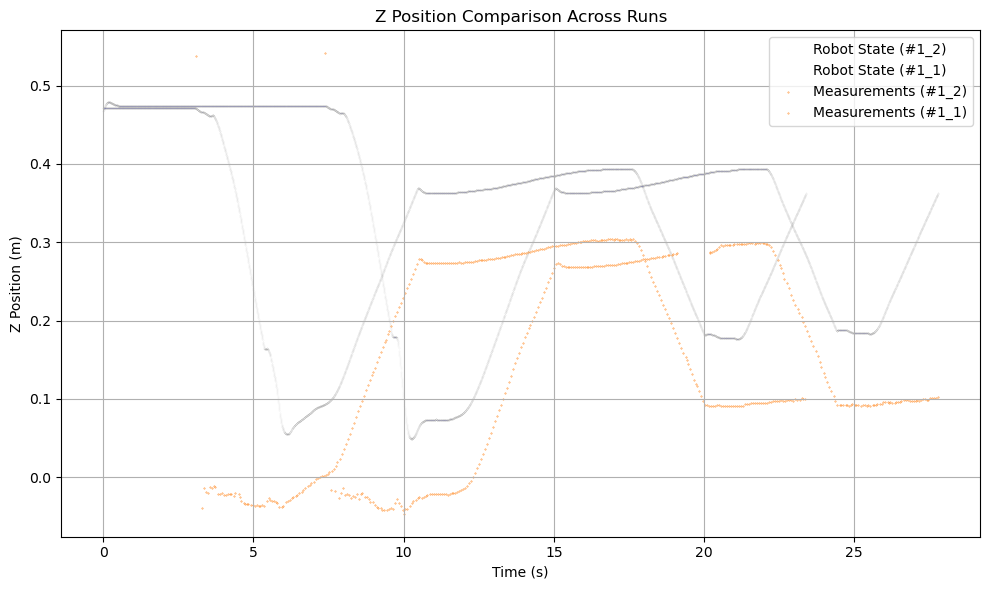

In [89]:


plot_multi_run_position_comparison(
    axis='z',
    exp_hashes=[exp_hash] * 2,
    run_numbers=[1, 2],
    log_dir=log_dir,
    visibility=[1, 1, 0, 0],
    visible_states=[2, 3, 4, 5, 6, 7],
    shade_states=False
)